In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


-----------------------------------------------

In [3]:
from torchvision import models

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.to(device)
model.eval()

d:\GSoC\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\GSoC\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:12<00:00, 8.32MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


-----------------------------------------------

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

-----------------------------------------------

In [5]:
from PIL import Image
import numpy as np
from tqdm import tqdm

def extract_embeddings(paths, batch_size=16):

    all_embeddings = []

    for i in tqdm(range(0,len(paths),batch_size)):

        batch_paths = paths[i:i+batch_size]
        batch = []

        for p in batch_paths:
            img = Image.open(p).convert('RGB')
            img = transform(img)
            batch.append(img)

        batch = torch.stack(batch).to(device)

        with torch.no_grad():
            feats = model(batch)

        feats = feats.cpu().numpy()
        feats = feats.reshape(feats.shape[0],-1)

        all_embeddings.append(feats)

    return np.vstack(all_embeddings)

-----------------------------------------------

In [6]:
import os

IMAGE_FOLDER = "images"

image_paths = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print("Total Images Found:", len(image_paths))

Total Images Found: 2945


-----------------------------------------------

In [7]:
print(image_paths[:5])

['images\\0.jpg', 'images\\100870.jpg', 'images\\101282.jpg', 'images\\102011.jpg', 'images\\102150.jpg']


-----------------------------------------------

In [9]:
import numpy as np
embeddings = extract_embeddings(image_paths)

np.save("nga_embeddings.npy", embeddings)
np.save("nga_image_paths.npy", np.array(image_paths))

print("Embeddings Saved!")

100%|██████████| 185/185 [00:31<00:00,  5.88it/s]


Embeddings Saved!


-----------------------------------------------

In [21]:
import faiss
import numpy as np

embeddings = np.load("nga_embeddings.npy")

faiss.normalize_L2(embeddings)

dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)

index.add(embeddings)

faiss.write_index(index, "nga_faiss.index")

print("FAISS Index Saved!")

FAISS Index Saved!


-----------------------------------------------

In [ ]:
#Instant Startup :Load Later 
embeddings = np.load("nga_embeddings.npy")
image_paths = np.load("nga_image_paths.npy", allow_pickle=True)

index = faiss.read_index("nga_faiss.index")

print("Index Loaded!")

Index Loaded!


-----------------------------------------------

In [12]:
def search_similar(image_path, k=5):

    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(img)

    query = feat.cpu().numpy().reshape(1,-1)
    faiss.normalize_L2(query)

    distances, indices = index.search(query, k)

    return indices[0]

-----------------------------------------------

In [22]:
i = 10

retrieved = search_similar(image_paths[i], k=5)

print("Query index:", i)
print("Retrieved indices:", retrieved)

Query index: 10
Retrieved indices: [  10 2518 2684 2666  313]


-----------------------------------------------

In [13]:
import matplotlib.pyplot as plt

def show_results(query_img, indices):

    plt.figure(figsize=(15,5))

    img = Image.open(query_img)
    plt.subplot(1,6,1)
    plt.imshow(img)
    plt.title("Query")
    plt.axis('off')

    for i, idx in enumerate(indices):
        simg = Image.open(image_paths[idx])
        plt.subplot(1,6,i+2)
        plt.imshow(simg)
        plt.title("Similar")
        plt.axis('off')

    plt.show()

-----------------------------------------------

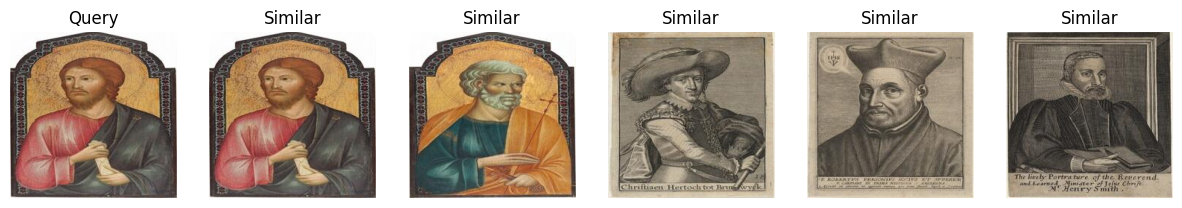

In [30]:
query = image_paths[0]

indices = search_similar(query, k=5)

show_results(query, indices)

-----------------------------------------------

In [23]:
def top1_accuracy(k=5):

    correct = 0

    for i in range(len(image_paths)):

        retrieved = search_similar(image_paths[i], k=k)

        if i in retrieved:
            correct += 1

    return correct / len(image_paths)

-----------------------------------------------

In [31]:
def recall_at_k(k=5):

    correct = 0

    for i in range(len(image_paths)):

        retrieved = search_similar(image_paths[i], k=k)

        if i in retrieved:
            correct += 1

    return correct / len(image_paths)

-----------------------------------------------

In [24]:
def mean_reciprocal_rank(k=10):

    score = 0

    for i in range(len(image_paths)):

        retrieved = search_similar(image_paths[i], k=k)

        for rank, idx in enumerate(retrieved):

            if idx == i:
                score += 1/(rank+1)
                break

    return score / len(image_paths)

-----------------------------------------------

In [32]:
print("Top-1 Accuracy:", top1_accuracy())
print("Recall@5:", recall_at_k(5))
print("MRR:", mean_reciprocal_rank())

Top-1 Accuracy: 1.0
Recall@5: 1.0
MRR: 0.999490662139219


-----------------------------------------------

# Evaluation Metrics

Since the NGA dataset subset does not contain labeled similarity annotations, evaluation was conducted using self-retrieval metrics where the query image itself is treated as the ground truth match. The similarity model was evaluated using Top-1 Accuracy, Recall@5 and Mean Reciprocal Rank (MRR).

The system achieved a Top-1 Accuracy of 1.0, Recall@5 of 1.0 and an MRR of 0.999, demonstrating that the learned deep feature embeddings effectively preserve visual similarity among paintings and enable accurate retrieval of similar artworks.